In [371]:
import pandas as pd
import numpy as np
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from imblearn.over_sampling import SMOTE
warnings.filterwarnings("ignore")
np.random.seed(42)

In [372]:
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import rank2d

In [373]:
grid_search_enable = True
cv = 2
verbose = 3
number_of_jobs = -1
rand_state = 101
test_size = 0.4

In [374]:
bdf = pd.read_csv("featured_bank_imputed_wo_duration_pattern.csv")

### Feature engineering

In [375]:
def euribor3m_bup(rate):
    if rate >0 and rate <= 0.25:
        return 'euri_000_025'
    if rate >0.25 and rate <= 0.5:
        return 'euri_025_050'
    if rate >0.5 and rate <= 0.75:
        return 'euri_050_075'
    if rate >0.75 and rate <= 1:
        return 'euri_075_100'
    if rate >1 and rate <= 1.25:
        return 'euri_100_125'
    if rate >1.25 and rate <= 1.5:
        return 'euri_125_150'
    if rate >1.5 and rate <= 1.75:
        return 'euri_150_175'
    if rate >1.75 and rate <= 2:
        return 'euri_175_200'
    if rate >2 and rate <= 2.25:
        return 'euri_200_225'
    if rate >2.25 and rate <= 2.5:
        return 'euri_225_250'
    if rate >2.5 and rate <= 2.75:
        return 'euri_250_275'
    if rate >2.75 and rate <= 3:
        return 'euri_275_300'
    if rate >3 and rate <= 3.25:
        return 'euri_300_325'
    if rate >3.25 and rate <= 3.5:
        return 'euri_325_350'
    if rate >3.5 and rate <= 3.75:
        return 'euri_350_375'
    if rate >4 and rate <= 4.25:
        return 'euri_400_425'
    if rate >4.25 and rate <= 4.5:
        return 'euri_425_450'
    if rate >4.5 and rate <= 4.75:
        return 'euri_450_475'
    if rate >4.75 and rate <= 5:
        return 'euri_475_500'
    if rate > 5:
        return 'euri_500'

In [376]:
bdf['f.euribor']=bdf['euribor3m'].apply(euribor3m_bup)

In [377]:
def age_group(age):
    if age >= 16 and age <=20:
        return '16_20'
    if age > 20 and age <=25:
        return '20_25'
    if age > 25 and age <=30:
        return '25_30'
    if age > 30 and age <=35:
        return '30_35'
    if age > 35 and age <=40:
        return '35_40'
    if age > 40 and age <=45:
        return '40_45'
    if age > 45 and age <=50:
        return '45_50'
    if age > 50 and age <=55:
        return '50_55'
    if age > 55 and age <=60:
        return '55_60'
    if age > 60 and age <=65:
        return '60_65'
    if age > 65 and age <=70:
        return '65_70'
    if age > 70 and age <=75:
        return '70_75'
    if age > 75 and age <=80:
        return '75_80'
    if age > 80 and age <=85:
        return '80_85'
    if age > 85 and age <=90:
        return '85_90'
    if age > 90:
        return '90_'

In [378]:
bdf['f.age_group']=bdf['age'].apply(age_group)

In [379]:
def festivals(month):
    # imputing festivals - apr: easter; jun:carnival; dec:christmas
    if month == 'apr' or month == 'jun' or month == 'dec':
        return 1
    else:
        return 0

In [380]:
bdf['f.festivals'] = bdf['month'].apply(festivals)

In [381]:
def bonus_months(month):
    # bonus paid twice in a year - may and nov
    if month == 'jun' or month == 'dec':
        return 1
    else:
        return 0

In [382]:
bdf['f.bonus_months']= bdf['month'].apply(bonus_months)

In [383]:
def commitment(housing, personal, marital):
    # if a person is married and has housing and personal loans, flag it as high commitment
    if housing == 'yes' and personal == 'yes' and marital == 'married':
        return 'high'
    if housing == 'no' and personal == 'no' and marital in ['single']:
        return 'low'
    else:
        return 'medium'

In [384]:
bdf['f.commitment'] = bdf.apply(lambda x: commitment(x.housing, x.loan, x.marital), axis=1)

In [385]:
def seasons(month):
    if month in ['mar','apr','may']:
        return 'spring'
    if month in ['jun','jul','aug']:
        return 'summer'
    if month in ['sep','oct','nov']:
        return 'autumn'
    if month in ['dec','jan','feb']:
        return 'winter'

In [386]:
bdf['f.seasons'] = bdf['month'].apply(lambda mon: seasons(mon))

In [387]:
def seasons_weightage(season):
    if season == 'autumn':
        return 21
    if season == 'spring':
        return 36
    if season == 'summer':
        return 40
    if season == "winter":
        return 2

In [388]:
#bdf ['f.season_weight'] = bdf['f.seasons'].apply(lambda season: seasons_weightage(season))

In [389]:
def retired(age):
    if age >= 65:
        return 'retired'
    else:
        return 'not-retired'

In [390]:
bdf['f.retired_status'] = bdf['age'].apply(lambda age: retired(age))

In [391]:
def marital_weightage(marital):
    if marital == 'divorced':
        return 1
    if marital == 'single':
        return 35
    if marital == 'married':
        return 54

In [392]:
#bdf['f.marital_weightage'] = bdf['marital'].apply(lambda status: marital_weightage(status))

In [393]:
def age_weightage(age):
    if age == '11_to_20':
        return 0.01
    if age == '21_to_30':
        return 0.23
    if age == '31_to_40':
        return 0.34
    if age == '41_to_50':
        return 0.18
    if age == '51_to_60':
        return 0.14
    if age == '61_to_70':
        return 0.04
    if age == '71_to_80':
        return 0.03
    if age == '81_to_90':
        return 0.01
    if age == '91_to_100':
        return 0.00
        

In [394]:
#bdf['f.age_weightage'] = bdf['f.age'].apply(lambda age: age_weightage(age))

In [395]:
def previous_user(previous):
    if previous == 0:
        return 'new user'
    else:
        return 'existing user'

In [396]:
bdf['f.user_type'] = bdf['previous'].apply(lambda previous: previous_user(previous))

In [397]:
def previous_no_of_times(previous):
    # if a user is part of the previous campaign, bin them
    if previous == 0:
        return 'no previous'
    if previous >= 1 and previous <= 3:
        return '1_to_3'
    if previous > 3:
        return 'gt_3'
    

In [398]:
bdf['f.previous_campaigns'] = bdf['previous'].apply(lambda previous: previous_no_of_times(previous))

In [399]:
def current_campaign_calls(calls):
    # how many times a user is called
    if calls == 1:
        return 'once'
    if calls >= 2 and calls <= 3:
        return 'twice to thrice '
    if calls > 3 and calls <= 6:
        return 'four to six times'
    if calls >= 7 and calls <= 10:
        return 'seven to ten times'
    if calls > 10:
        return 'more than ten times'
    

In [400]:
bdf['f.current_campaign_calls'] = bdf['campaign'].apply(lambda calls: current_campaign_calls(calls))

In [401]:
def first_time_user_calls(previous, campaigns):
    # first time user - not a part of previous campaign
    # first time the user is speaking - what's the conversion rate
    if previous == 0:
        if campaigns == 1:
            return 'first time called'
        if campaigns >= 2 and campaigns <= 3:
            return 'called atleast twice'
        if campaigns > 3:
            return 'called atleast thrice'
        else:
            return 'more than thrice'
    else:
        return 'returning user'

In [402]:
bdf['f.first_time_user_calls'] = bdf.apply(lambda x: first_time_user_calls(x.previous, x.campaign), axis=1)

In [403]:
def savings_intention(job):
    if job in ['admin.','blue-collar','technician']:
        return 100
    elif job in ['retired','management','services']:
        return 50
    else:
        return 25

In [404]:
bdf['f.savings_intent_factor'] = bdf['job'].apply(lambda job: savings_intention(job))

In [405]:
def age_range_weightage(age):
    if age <= 24:
        return 0.15
    if age >=25 and age <= 69:
        return 0.61
    if age >= 70 and age <= 80:
        return 0.13
    if age > 80:
        return 0.04

In [406]:
bdf['f.age_range_weightage'] = bdf['age'].apply(lambda age: age_range_weightage(age))

In [407]:
def avg_income_distribution(salary, marital):
    if marital == 'married':
        return round((salary/3),2)
    if marital == 'single':
        return salary
    if marital == 'divorced':
        return round((salary/2),2)
    

In [408]:
#bdf['f.avg_income_dist'] = bdf.apply(lambda x: avg_income_distribution(x['f.salary'], x['marital']), axis=1)

In [409]:
def p_days_bin(pdays):
    if pdays >=0 and pdays <=6:
        return 'within a week'
    if pdays >=7 and pdays <=13:
        return 'within two weeks'
    if pdays >= 14 and pdays <=20:
        return 'within three weeks'
    if pdays > 20:
        return 'more than three weeks'

In [410]:
bdf['f.pdays'] = bdf['pdays'].apply(lambda days: p_days_bin(days))

In [411]:
def year_weightage(year):
    if year == "Y2008":
        return 5
    if year == "Y2009":
        return 14
    if year == "Y2010":
        return 52

In [412]:
#bdf['f.year_weightage'] = bdf['f.year'].apply(lambda year: year_weightage(year))

In [413]:
def recession_strength(year, month):
    if year == "Y2008":
        if month in ['mar','apr','may','jun','jul','aug','sep','oct','nov','dec']:
            return 'peak'
    elif year == "Y2009":
        if month in ['mar','apr','may']:
            return 'peak'
        else:
            return 'non-peak'
    else:
        return 'non-peak'
    

In [414]:
bdf['f.recession_strength'] = bdf.apply(lambda x: recession_strength(x['f.year'],x['month']), axis=1)

In [415]:
# To be removed
def week_breakup(day):
    if day == "mon":
        return 'week_start'
    if day in ['tue','wed','thu']:
        return 'week_mid'
    if day in ['fri']:
        return 'week_end'

In [416]:
bdf['f.week_breakup'] = bdf['day_of_week'].apply(week_breakup)

In [417]:
# to be removed
def week_day_weightage(weekday):
    if weekday == 'week_start':
        return 14
    if weekday == 'week_mid':
        return 38
    if weekday == 'week_end':
        return 14

In [418]:
#bdf['f.week_day_weightage'] = bdf['f.week_breakup'].apply(week_day_weightage)

In [419]:
def emp_rate_change(rate):
    if rate > 0:
        return 'positive'
    else:
        return 'negative'

In [420]:
bdf['f.emp_var_rate'] = bdf['emp.var.rate'].apply(emp_rate_change)

In [421]:
def cons_price_bin(index):
	if index >=92 and index <=92.5:
		return 'gt_92_lt_92.5'
	if index >92.5 and index <= 93:
		return 'gt_925_lt_93'
	if index >93 and index <= 93.5:
		return 'gt_93_lt_935'
	if index >93.5 and index <= 94:
		return 'gt_935_lt_94'
	if index >94 and index <= 94.5:
		return 'gt_94_lt_94.5'
	if index >94.5 and index <= 95:
		return 'gt_945_lt_95'
	if index <92:
		return 'lt_92'
	if index >95:
		return 'gt_95'

In [422]:
bdf['f.cons.price.bin'] = bdf['cons.price.idx'].apply(cons_price_bin)

In [423]:
def emp_var_bin(index):
	if index < -3.5:
		return 'lt_min_3.5'
	if index >= -3.5 and index <= -3:
		return 'gt_min_35_lt_3'
	if index > -3 and index <= -2.5:
		return 'gt_min_3_lt_25'
	if index >-25 and index <= -2:
		return 'gt_min_25_lt_2'
	if index >-2 and index <= -1.5:
		return 'gt_min_2_lt_15'
	if index >-1.5 and index <= -1:
		return 'gt_min_15_lt_1'
	if index >-1 and index <= -0.5:
		return 'gt_min_1_lt_point5'
	if index >-0.5 and index <= 0:
		return 'gt_min_05_lt_0'
	if index >0 and index <= 0.5:
		return 'gt_0_lt_05'
	if index >0.5 and index <= 1:
		return 'gt_05_lt_05'
	if index > 1:
		return 'gt_1'

In [424]:
bdf['f.emp.var.bin'] = bdf['emp.var.rate'].apply(emp_var_bin)

In [425]:
def cons_conf_bin(index):
	if index < -51:
		return 'lt_51'
	if index >= -51 and index <= -46:
		return 'gt_51_lt_46'
	if index > -46 and index <= -41:
		return 'gt_46_lt_41'
	if index > -41 and index <= -36:
		return 'gt_41_lt_36'
	if index > -36 and index <= -31:
		return 'gt_36_lt_31'
	if index > -31 and index <= -26:
		return 'gt_31_lt_26'
	if index > -26:
		return 'gt_26'

In [426]:
bdf['f.cons.conf.bin'] = bdf['cons.conf.idx'].apply(cons_conf_bin)

In [427]:
def buy_prob_user_job(user_type, job):
    if user_type == "existing user":
        if job in ['admin.','housemaid','management','retired','student','technician','unemployed']:
            return 'high'
        else:
            return 'low'
    else:
        return 'low'

In [428]:
#bdf['f.userjob_buy.prob'] = bdf.apply(lambda x: buy_prob_user_job(x['f.user_type'], x['job']), axis=1)

In [429]:
def salaried_or_not(job):
    if job in ['admin.','blue-collar', 'housemaid','management','services','retired','technician']:
        return 'salaried'
    else:
        return 'not salaried'

In [430]:
bdf['f.sal_or_not'] = bdf['job'].apply(salaried_or_not)

In [431]:
def quarter(month):
    if month in ['apr','may','jun']:
        return 'Q1'
    if month in ['jul','aug','sep']:
        return 'Q2'
    if month in ['oct','nov','dec']:
        return 'Q3'
    if month in ['jan','feb','mar']:
        return 'Q4'

In [432]:
bdf['f.quarter'] = bdf['month'].apply(quarter)

In [433]:
def into_loans(housing, personal):
    if housing == 'no' and personal == "no":
        return 'not_into_loans'
    else:
        return 'into_loans'

In [434]:
bdf['f.into_loans'] = bdf.apply(lambda x: into_loans(x.housing, x.loan), axis=1)

In [435]:
base_sal = {
    'housemaid' : 500,
    'services' : 700,
    'admin.' : 600,
    'blue-collar' : 500,
    'technician' : 600,
    'retired' : 500,
    'management' : 1600,
    'unemployed' : 400,
    'self-employed' : 800,
    'entrepreneur' : 1200,
    'student' : 400
}

In [436]:
edu_sal = {
    'basic.4y' : 1,
    'high.school' : 1.6,
    'basic.6y' : 1.2,
    'basic.9y' : 1.4,
    'professional.course' : 1.6,
    'university.degree' : 2,
    'illiterate' : 1
}

In [437]:
def salary_job_education(job, education):
    job_base_sal = base_sal[job]
    edu_factor = edu_sal[education]
    if job in ['retired','unemployed','self-employed','entrepreneur']:
        sal = job_base_sal * edu_factor * 12
    else:
        sal = job_base_sal * edu_factor * 14
    return sal

In [438]:
bdf['f.income'] = bdf.apply(lambda x: salary_job_education(x.job, x.education), axis=1)

In [439]:
def income_tax(salary):
    if salary >=0 and salary <=7112:
        return 14.5
    if salary >=7113 and salary <=10732:
        return 23
    if salary >=10733 and salary <=20322:
        return 28.5
    if salary >=20323 and salary <=25075:
        return 35
    if salary >=25076 and salary <=36967:
        return 37
    if salary >=36968:
        return 45

In [440]:
bdf['f.income_tax'] = bdf['f.income'].apply(lambda salary: income_tax(salary))

In [441]:
def econ_status(income):
    if income <= 7800:
        return 'lower class'
    if income >7800 and income <= 26400:
        return 'middle class'
    if income > 26400:
        return 'upper class'

In [442]:
bdf['f.econ_status'] = bdf['f.income'].apply(econ_status)

In [443]:
def buy_prob_status_marital(marital_status):
    if marital_status in ['married','single']:
        return 'high'
    else:
        return 'low'

In [444]:
bdf['f.user.buy.prob'] = bdf['marital'].apply(buy_prob_status_marital)

In [445]:
def bailout_period(year):
    if year == "Y2010":
        return "bailout"
    else:
        return "non-bailout"

In [446]:
#bdf['f.bailout_status'] = bdf['f.year'].apply(bailout_period)

In [447]:
def education_level(education):
    if education in ['illiterate','basic.4y','basic.6y','basic.9y']:
        return 'basic-education'
    if education in ['high.school','professional.course']:
        return 'medium-education'
    if education in ['university.degree']:
        return 'high-education'

In [448]:
bdf['f.education'] = bdf['education'].apply(education_level)

In [449]:
def age_to_retirement(age):
    if age < 65:
        return 65 - age
    else:
        return 0

In [450]:
bdf['f.age_to_retire'] = bdf['age'].apply(age_to_retirement)

In [451]:
def age_range_to_retire(diff_age):
    if diff_age == 0:
        return 0
    if diff_age >=1 and diff_age <=5:
        return 0.3
    if diff_age >=6 and diff_age <=35:
        return 0.1
    if diff_age >= 36 and diff_age <= 40:
        return 0.14
    if diff_age >= 41 and diff_age <= 45:
        return 0.22
    if diff_age >= 46:
        return 0.45

In [452]:
bdf['f.age_to_retire_weight'] = bdf['f.age_to_retire'].apply(age_range_to_retire)

In [453]:
def age_to_eol(age):
    if age < 80:
        return 80 - age
    else:
        return 0

In [454]:
bdf['f.age_to_death'] = bdf['age'].apply(age_to_eol)

In [455]:
def age_range_to_death(diff_age):
    if diff_age >=0 and diff_age <= 19:
        return '0_to_19'
    if diff_age >=20 and diff_age <= 39:
        return '20_to_39'
    if diff_age >=40 and diff_age <=59:
        return '40_to_59'
    if diff_age >=60:
        return '60_to_'

In [456]:
bdf['f.remaining_age'] = bdf['f.age_to_death'].apply(age_range_to_death)

In [457]:
def unemployment_rate(recession_strength, age_range, salaried):
    if recession_strength == "peak":
        if age_range in ['21_to_30','31_to_40']:
            return -30
        else:
            return -8
    else:
        return -10

In [458]:
bdf['f.unemployment'] = bdf.apply(lambda x: unemployment_rate(x['f.recession_strength'],x['f.age'],x['f.sal_or_not']), axis=1)

### Feature Analysis

In [459]:
dropped_columns= ['s.no', 'age','nr.employed','default','pdays', 'emp.var.rate', 'euribor3m',
                  'campaign','cons.price.idx','cons.conf.idx', 'f.quarter','f.income_tax','f.age_to_death', 'f.sal_or_not',
                  'f.age_to_retire', 'f.unemployment', 'f.income','f.interest_rate','f.age','f.pattern','f.user.buy.prob',
                  'f.econ_status','f.remaining_age','f.education','f.seasons',
                 ]
categorical_columns=['job','marital','housing','loan','education','contact','month','day_of_week',
                     'poutcome','f.euribor','f.age_group', 'f.commitment','f.week_breakup',
                    'f.retired_status', 'f.user_type','f.previous_campaigns','f.current_campaign_calls',
                     'f.first_time_user_calls','f.pdays', 'f.emp_var_rate','f.year','f.cons.price.bin',
                     'f.emp.var.bin','f.cons.conf.bin','f.recession_strength',
                     'f.into_loans'
                    ]

In [460]:
# drop the columns
bdf.drop(dropped_columns, axis=1, inplace=True)

In [461]:
#convert columns of object type to categorical columns
bdf_cat = bdf[categorical_columns].astype('category')

In [462]:
bdf[categorical_columns] = bdf[categorical_columns].astype('category')

In [463]:
# drop bdf categorical columns from the dataframe
bdf_noncat = bdf.drop(categorical_columns,axis=1)

In [464]:
bdf_noncat.columns

Index(['previous', 'y', 'f.festivals', 'f.bonus_months',
       'f.savings_intent_factor', 'f.age_range_weightage',
       'f.age_to_retire_weight'],
      dtype='object')

In [465]:
bdf.to_csv('testv6.csv')

In [466]:
bdf.corr()

,previous,f.festivals,f.bonus_months,f.savings_intent_factor,f.age_range_weightage,f.age_to_retire_weight
previous,1.000000,-0.000189,-0.057301,-0.044558,-0.118393,0.048344
f.festivals,-0.000189,1.000000,0.791492,-0.025942,-0.020965,0.018492
f.bonus_months,-0.057301,0.791492,1.000000,-0.013203,0.008488,0.007078
f.savings_intent_factor,-0.044558,-0.025942,-0.013203,1.000000,0.139925,-0.058298
f.age_range_weightage,-0.118393,-0.020965,0.008488,0.139925,1.000000,-0.271152
f.age_to_retire_weight,0.048344,0.018492,0.007078,-0.058298,-0.271152,1.000000


In [467]:
# use one hot encoding for categorical columns
bdf_cat_one_hot = pd.get_dummies(bdf_cat)

In [468]:
bdf_cat_one_hot.shape

(41188, 126)

In [469]:
#concat categorical df with non categorical df
bdf_master = pd.concat([bdf_noncat, bdf_cat_one_hot], axis=1)

In [470]:
# store only the target variable column
y = bdf_master.pop('y')

In [471]:
# remove the target variable column from the master dataset
X = bdf_master

In [472]:
sm = SMOTE()

In [473]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=101)

In [474]:
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

In [475]:
X_train.shape

(24712, 132)

In [476]:
X_train_sm.shape

(43804, 132)

In [477]:
# the propotion of yes and no looks the same

### Visualizing classification report

In [478]:
def show_classification_rpt(model):
    visualizer = ClassificationReport(model, classes=['no','yes'], cmap="YlGn", size=(600,300))
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

# Model Building

In [479]:
# function that fits and predicts
def fit_predict(algo,X_train, X_test, y_train, y_test):
    algo.fit(X_train, y_train)
    y_pred = algo.predict(X_test)
    return y_pred

## Logistic Regression

In [480]:
logit = LogisticRegression()

In [481]:
print("Accuracy with Logistic Regression", end=': ')
y_pred_logit = fit_predict(logit, X_train_sm, X_test, y_train_sm, y_test)
logit_accuracy = accuracy_score(y_test, y_pred_logit)
print(logit_accuracy)

Accuracy with Logistic Regression: 0.8892935178441369


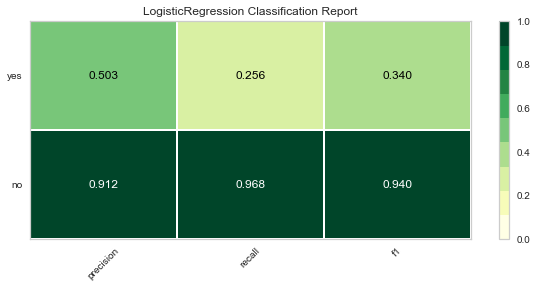

In [482]:
show_classification_rpt(logit)

In [483]:
print(classification_report(y_test, y_pred_logit))

              precision    recall  f1-score   support

          no       0.91      0.97      0.94     14646
         yes       0.50      0.26      0.34      1830

    accuracy                           0.89     16476
   macro avg       0.71      0.61      0.64     16476
weighted avg       0.87      0.89      0.87     16476



In [484]:
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred_logit))

Confusion Matrix:
[[14183   463]
 [ 1361   469]]


## Decision Tree

In [485]:
tree = DecisionTreeClassifier(random_state=rand_state)

In [486]:
print("Accuracy with Decision Tree", end=': ')
y_pred_tree = fit_predict(tree, X_train_sm, X_test, y_train_sm, y_test)
tree_accuracy = accuracy_score(y_test, y_pred_tree)
print(tree_accuracy)

Accuracy with Decision Tree: 0.8471716436028163


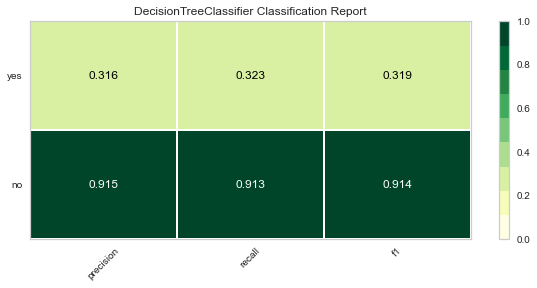

In [487]:
show_classification_rpt(tree)

In [488]:
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred_tree))

Confusion Matrix:
[[13367  1279]
 [ 1239   591]]


### Hyper Parameter Tuning

In [489]:
def fit_predict_dt(train, test, y_train, y_test, scaler, max_depth,
               criterion = 'entropy', max_features=1, min_samples_split=4):
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    dt = DecisionTreeClassifier(criterion = criterion, max_depth=max_depth,
                               random_state= 101, max_features=max_features,
                               min_samples_split=min_samples_split)
    dt.fit(train_scaled, y_train)
    y_pred = dt.predict(test_scaled)
    return y_pred

### Max depth parameter tuning

In [490]:
list_max_depth = []

In [491]:
for i in range(5,50):
    print("Accuracy score using max_depth = ", i, end = ':')
    y_pred_tree_hpt = fit_predict_dt(X_train_sm, X_test, y_train_sm, y_test, StandardScaler(), i)
    dt_max_depth = accuracy_score(y_test, y_pred_tree_hpt)
    print(dt_max_depth)
    list_max_depth.append(dt_max_depth)
    
max_depth_tuned = list_max_depth.index(max(list_max_depth))+1
print(max_depth_tuned)

Accuracy score using max_depth =  5:0.5132313668366109
Accuracy score using max_depth =  6:0.5515294974508376
Accuracy score using max_depth =  7:0.6946467589220685
Accuracy score using max_depth =  8:0.6945860645787812
Accuracy score using max_depth =  9:0.7224447681476086
Accuracy score using max_depth =  10:0.6982884195193008
Accuracy score using max_depth =  11:0.6205389657683904
Accuracy score using max_depth =  12:0.7125515901917941
Accuracy score using max_depth =  13:0.7631706724933236
Accuracy score using max_depth =  14:0.7146151978635591
Accuracy score using max_depth =  15:0.7710609371206604
Accuracy score using max_depth =  16:0.7313061422675406
Accuracy score using max_depth =  17:0.7401068220441854
Accuracy score using max_depth =  18:0.7875697984947803
Accuracy score using max_depth =  19:0.7748239864044671
Accuracy score using max_depth =  20:0.7796795338674436
Accuracy score using max_depth =  21:0.7569798494780287
Accuracy score using max_depth =  22:0.78665938334547

### Max features tuning

In [492]:
dict_max_features = {}

In [493]:
for i in np.arange(0.1,1.0,0.1):
    print('Accuracy score using max features =', i, end = ":")
    y_pred_max_features = fit_predict_dt(X_train_sm, X_test, y_train_sm, y_test, StandardScaler(), max_depth=max_depth_tuned, max_features=i)
    dt_max_features = accuracy_score(y_test, y_pred_max_features)
    print(dt_max_features)
    dict_max_features[i]=dt_max_features

max_feature_tuned = max(dict_max_features, key=dict_max_features.get)
print(max_feature_tuned)

Accuracy score using max features = 0.1:0.8504491381403253
Accuracy score using max features = 0.2:0.8550619082301529
Accuracy score using max features = 0.30000000000000004:0.8562151007526099
Accuracy score using max features = 0.4:0.8558509346928866
Accuracy score using max features = 0.5:0.8514809419762078
Accuracy score using max features = 0.6:0.851845108035931
Accuracy score using max features = 0.7000000000000001:0.855668851663025
Accuracy score using max features = 0.8:0.852391357125516
Accuracy score using max features = 0.9:0.8535445496479728
0.30000000000000004


### Min samples split tuning

In [494]:
dict_min_samples_split = {}

In [495]:
for i in range(2,10):
    print('Accuracy score using min samples split=', i, end=":")
    y_pred_min_split = fit_predict_dt(X_train_sm, X_test, y_train_sm, y_test, StandardScaler(), max_depth=max_depth_tuned, max_features=max_feature_tuned, min_samples_split=i)
    dt_min_sample_split = accuracy_score(y_test, y_pred_min_split)
    print(dt_min_sample_split)
    dict_min_samples_split[i] = dt_min_sample_split
    
min_sample_split_tuned = max(dict_min_samples_split, key=dict_min_samples_split.get)
print(min_sample_split_tuned)

Accuracy score using min samples split= 2:0.8441976207817431
Accuracy score using min samples split= 3:0.8541514930808448
Accuracy score using min samples split= 4:0.8562151007526099
Accuracy score using min samples split= 5:0.8590070405438213
Accuracy score using min samples split= 6:0.8573682932750668
Accuracy score using min samples split= 7:0.8554260742898762
Accuracy score using min samples split= 8:0.8550619082301529
Accuracy score using min samples split= 9:0.857428987618354
5


### Criterion tuning

In [496]:
dict_index_tuned = {}

In [497]:
for i in ['gini','entropy']:
    print("Accuracy score using criterion: ", i, end = ':')
    y_pred_index_score = fit_predict_dt(X_train_sm, X_test, y_train_sm, y_test, StandardScaler(), max_depth=max_depth_tuned, max_features = max_feature_tuned, min_samples_split=min_sample_split_tuned, criterion= i)
    dt_index_score = accuracy_score(y_test, y_pred_index_score)
    print(dt_index_score)
    dict_index_tuned[i] = dt_index_score

dt_index_tuned = max(dict_index_tuned, key=dict_index_tuned.get)
print(dt_index_tuned)

Accuracy score using criterion:  gini:0.8558509346928866
Accuracy score using criterion:  entropy:0.8590070405438213
entropy


### Rerunning decision tree with best parameters

In [498]:
tree_best_pred  =  fit_predict_dt(X_train_sm, X_test, y_train_sm, y_test, StandardScaler(), max_depth=max_depth_tuned, max_features = max_feature_tuned, min_samples_split=min_sample_split_tuned, criterion= dt_index_tuned)
dt_best_param_score = accuracy_score(y_test, tree_best_pred)
print("Accuracy score for decision tree using best param: ", end = ':')
print(dt_best_param_score)

Accuracy score for decision tree using best param: :0.8590070405438213


In [499]:
tree1 = DecisionTreeClassifier(criterion = dt_index_tuned, max_depth=max_depth_tuned,
                               random_state= rand_state, max_features=max_feature_tuned,
                               min_samples_split=min_sample_split_tuned)

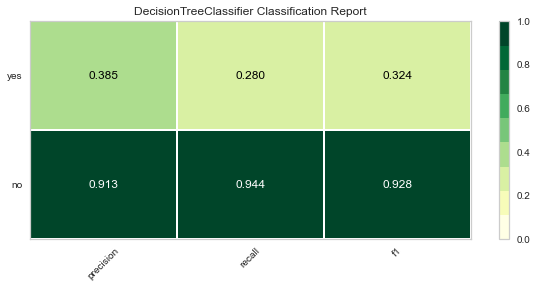

In [500]:
show_classification_rpt(tree1)

In [501]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, tree_best_pred))

Confusion Matrix:
[[13628  1018]
 [ 1305   525]]


### Using polynomial features

In [502]:
def create_poly(train, test, degree):
    poly = PolynomialFeatures(degree = degree)
    train_poly = poly.fit_transform(train)
    test_poly = poly.fit_transform(test)
    return train_poly, test_poly

In [503]:
## polynomial features taking a lot of time as the number of columns are more. Hence commented the following piece of code

In [504]:
# for degree in [1,2,3,4]:
#     train_poly, test_poly = create_poly(X_train, X_test, degree)
#     print("polynomial degree", degree)
#     fit_predict(train_poly, test_poly, y_train, y_test, StandardScaler(), 16, max_features = 0.2,min_samples_split=4, criterion='entropy')
#     print(10 *'-')

## Random Forest

In [505]:
forest = RandomForestClassifier(criterion='entropy', oob_score=True)

In [506]:
print("Accuracy with Random Forest", end=': ')
rf_pred = fit_predict(forest, X_train_sm, X_test, y_train_sm, y_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(rf_accuracy)

Accuracy with Random Forest: 0.8800072833211945


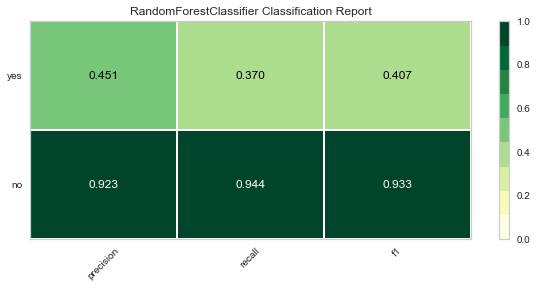

In [507]:
show_classification_rpt(forest)

In [508]:
print("Confusion Matrix:")
print(confusion_matrix(y_test,rf_pred))

Confusion Matrix:
[[13821   825]
 [ 1152   678]]


### Parameter tuning using Grid Search

In [509]:
params = {
    'n_estimators': [300,500,700],
    'max_depth': [20,25,30,35],
    'min_samples_leaf': [3,5,7]
}

In [510]:
gs = GridSearchCV(forest, params, cv=cv, verbose=verbose, n_jobs=number_of_jobs)

In [511]:
if grid_search_enable == True:
    gs.fit(X_train_sm, y_train_sm)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 13.6min finished


In [512]:
if grid_search_enable == True:
    print(gs.best_params_)

{'max_depth': 30, 'min_samples_leaf': 3, 'n_estimators': 700}


In [513]:
if grid_search_enable == True:
    forest_best_max_depth = gs.best_params_['max_depth']
    forest_best_min_samples = gs.best_params_['min_samples_leaf']
    forest_best_n_estimators = gs.best_params_['n_estimators']
    #forest_best_criterion = gs.best_params_['criterion']

In [514]:
if grid_search_enable == True:
    print(gs.best_estimator_)

RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_leaf=3,
                       n_estimators=700, oob_score=True)


### Retraining with best estimators

In [515]:
if grid_search_enable == True:
    forest1 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=forest_best_max_depth, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=forest_best_min_samples, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=forest_best_n_estimators,
                       n_jobs=number_of_jobs, oob_score=True, random_state=rand_state,
                       verbose=0, warm_start=False)

In [516]:
if grid_search_enable == True:
    forest1.fit(X_train_sm, y_train_sm)

In [517]:
if grid_search_enable == True:
    pred_forest1 = forest1.predict(X_test)

In [518]:
if grid_search_enable == True:
    print("Accuracy with Random Forest after Hyper Parameter Tuning", end=': ')
    rf_hyper_accuracy = accuracy_score(y_test, pred_forest1)
    print(rf_hyper_accuracy)

Accuracy with Random Forest after Hyper Parameter Tuning: 0.8803107550376305


In [519]:
if grid_search_enable == True:
    for x in sorted(list(zip(forest1.feature_importances_, X_train.columns)), reverse=True):
        print(x)

(0.04089978405952463, 'f.recession_strength_non-peak')
(0.03969276377167128, 'f.recession_strength_peak')
(0.028153822672590437, 'f.age_to_retire_weight')
(0.0275775575784591, 'poutcome_failure')
(0.025905935002405622, 'contact_telephone')
(0.02589197118408651, 'f.year_Y2008')
(0.02359964759150204, 'f.age_group_35_40')
(0.019301449535997876, 'f.age_group_40_45')
(0.019187022693662917, 'f.emp_var_rate_negative')
(0.01895752507132935, 'f.age_group_30_35')
(0.018957173250386605, 'f.emp.var.bin_gt_1')
(0.01765868607664617, 'f.emp_var_rate_positive')
(0.01756634382736761, 'education_high.school')
(0.017430762298571413, 'f.age_group_45_50')
(0.01708098834395462, 'education_university.degree')
(0.015828093410038786, 'marital_married')
(0.015730296333191313, 'education_basic.9y')
(0.014875892678348799, 'f.savings_intent_factor')
(0.014130676584409599, 'day_of_week_thu')
(0.013894011274086826, 'f.euribor_euri_475_500')
(0.013742203870105144, 'marital_single')
(0.013539994017906131, 'month_may')

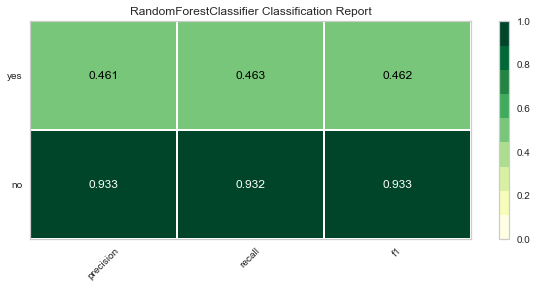

In [520]:
if grid_search_enable == True:
    show_classification_rpt(forest1)

In [521]:
if grid_search_enable == True:
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, pred_forest1))

Confusion Matrix:
[[13656   990]
 [  982   848]]


## Accuracy Summary Without Boosting

In [522]:
print("Accuracy with Logistic Regression", end=': ')
print(logit_accuracy)
print("Accuracy with Decision Tree", end=': ')
print(tree_accuracy)
print("Accuracy of Decision Tree after Hyper Parameter Tuning: ", end = ':')
print(dt_best_param_score)
print("Accuracy with Random Forest", end=': ')
print(rf_accuracy)
if grid_search_enable == True:
    print("Accuracy with Random Forest after Hyper Parameter Tuning", end=': ')
    print(rf_hyper_accuracy)

Accuracy with Logistic Regression: 0.8892935178441369
Accuracy with Decision Tree: 0.8471716436028163
Accuracy of Decision Tree after Hyper Parameter Tuning: :0.8590070405438213
Accuracy with Random Forest: 0.8800072833211945
Accuracy with Random Forest after Hyper Parameter Tuning: 0.8803107550376305


## AdaBoost

In [523]:
from sklearn.ensemble import AdaBoostClassifier

In [524]:
adabst_fit = AdaBoostClassifier(base_estimator=logit, random_state=rand_state, n_estimators=100)

In [525]:
adabst_fit.fit(X_train_sm, y_train_sm)

AdaBoostClassifier(base_estimator=LogisticRegression(), n_estimators=100,
                   random_state=101)

In [526]:
print("Accuracy with Ada Boost", end=': ')
ada_boost_predict = adabst_fit.predict(X_test)
ada_boost_accuracy = accuracy_score(y_test,ada_boost_predict)
print(ada_boost_accuracy)

Accuracy with Ada Boost: 0.8825564457392571


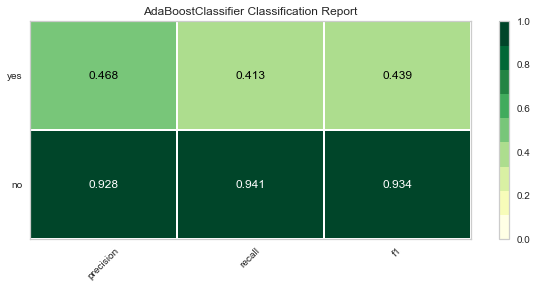

In [527]:
show_classification_rpt(adabst_fit)

In [528]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, ada_boost_predict))

Confusion Matrix:
[[13785   861]
 [ 1074   756]]


### Adaboost with Grid Search

In [529]:
params_adaboost = {
    'n_estimators': [100,200,300],
    'base_estimator': [logit, tree1],
    'learning_rate': [0.5,0.75,1.0]
}

In [530]:
ada_gs = GridSearchCV(adabst_fit, params_adaboost, cv=cv, n_jobs=number_of_jobs)

In [531]:
if grid_search_enable == True:
    ada_gs.fit(X_train_sm, y_train_sm)

In [532]:
if grid_search_enable == True:
    adabst_best_estimator = ada_gs.best_params_['base_estimator']
    adabst_best_learning_rate = ada_gs.best_params_['learning_rate']
    adabst_best_n_estimators = ada_gs.best_params_['n_estimators']

In [533]:
if grid_search_enable == True:
    ada_gs.best_params_

### Adaboost - Retraining with best estimators

In [534]:
if grid_search_enable == True:
    ada_best = AdaBoostClassifier(base_estimator=adabst_best_estimator, random_state=rand_state,
                                  n_estimators=adabst_best_n_estimators, learning_rate=adabst_best_learning_rate)

In [535]:
if grid_search_enable == True:
    ada_best.fit(X_train_sm, y_train_sm)
    ada_best_predict = ada_best.predict(X_test)

In [536]:
if grid_search_enable == True:
    print("Accuracy with Adaboost after Hyper Parameter Tuning", end=': ')
    ada_best_hyper_accuracy = accuracy_score(y_test, ada_best_predict)
    print(ada_best_hyper_accuracy)

Accuracy with Adaboost after Hyper Parameter Tuning: 0.8744840980820587


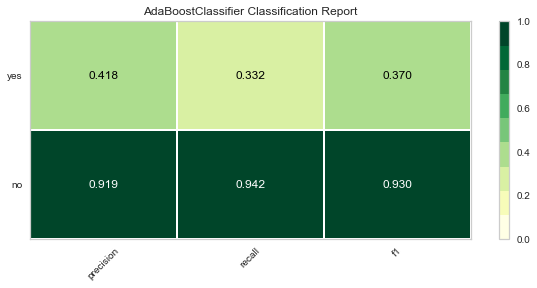

In [537]:
if grid_search_enable == True:
    show_classification_rpt(ada_best)

In [538]:
if grid_search_enable == True:
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, ada_best_predict))

Confusion Matrix:
[[13800   846]
 [ 1222   608]]


## Gradient Boost

In [539]:
from sklearn.ensemble import GradientBoostingClassifier

In [540]:
gbc_fit = GradientBoostingClassifier(n_estimators=500,
                                     min_samples_split=2,min_samples_leaf=1,max_depth=1,random_state=rand_state)

In [541]:
gbc_fit.fit(X_train_sm, y_train_sm)

GradientBoostingClassifier(max_depth=1, n_estimators=500, random_state=101)

In [542]:
print("Accuracy with Gradient Boost", end=': ')
y_pred_gbc = gbc_fit.predict(X_test)
gbc_accuracy = accuracy_score(y_test, y_pred_gbc)
print(gbc_accuracy)

Accuracy with Gradient Boost: 0.8750910415149308


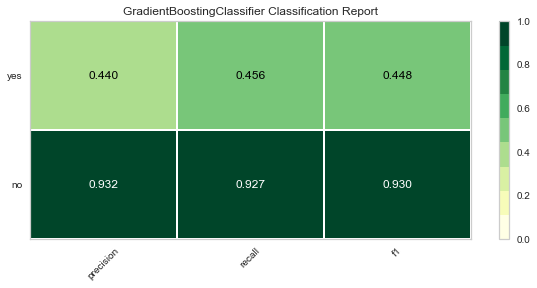

In [543]:
show_classification_rpt(gbc_fit)

In [544]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gbc))

Confusion Matrix:
[[13583  1063]
 [  995   835]]


### Gradient boost with Grid Search

In [545]:
params_gbc = {
    'n_estimators': [100,300,500],
    'max_depth': [2,3,4],
    'learning_rate': [0.05,0.075,0.1]
}

In [546]:
gbc_gs = GridSearchCV(gbc_fit, params_gbc, cv=cv, n_jobs=number_of_jobs)

In [547]:
if grid_search_enable == True:
    gbc_gs.fit(X_train_sm, y_train_sm)

In [548]:
if grid_search_enable == True:
    gbc_best_estimator = gbc_gs.best_params_['n_estimators']
    gbc_best_max_depth = gbc_gs.best_params_['max_depth']
    gbc_best_learning_rate = gbc_gs.best_params_['learning_rate']

In [549]:
if grid_search_enable == True:
    print(gbc_gs.best_params_)

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500}


### Gradient Boost - With Best Parameters

In [550]:
if grid_search_enable == True:
    gbc_best = GradientBoostingClassifier(n_estimators=gbc_best_estimator,
                                     min_samples_split=2,min_samples_leaf=1,max_depth=gbc_best_max_depth,random_state=rand_state,
                                         learning_rate=gbc_best_learning_rate)

In [551]:
if grid_search_enable == True:
    gbc_best.fit(X_train_sm, y_train_sm)
    gbc_best_predict = gbc_best.predict(X_test)

In [552]:
if grid_search_enable == True:
    print("Accuracy with Gradient Boost after Hyper Parameter Tuning", end=': ')
    gbc_best_hyper_accuracy = accuracy_score(y_test, gbc_best_predict)
    print(gbc_best_hyper_accuracy)

Accuracy with Gradient Boost after Hyper Parameter Tuning: 0.8939062879339645


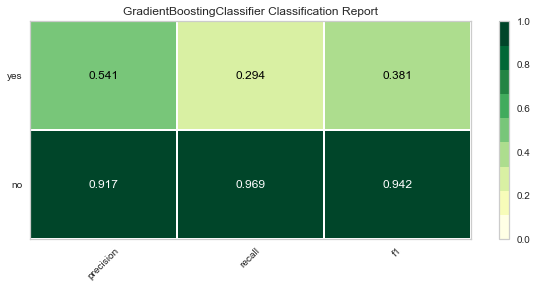

In [553]:
if grid_search_enable == True:
    show_classification_rpt(gbc_best)

In [554]:
if grid_search_enable == True:
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, gbc_best_predict))

Confusion Matrix:
[[14190   456]
 [ 1292   538]]


## LGBM

In [555]:
from lightgbm import LGBMClassifier

In [556]:
LGBM = LGBMClassifier(n_jobs=number_of_jobs, num_leaves=31)
LGBM.fit(X_train_sm, y_train_sm)

LGBMClassifier()

In [557]:
LGBM_predict = LGBM.predict(X_test)

In [558]:
print("Accuracy with LGBM", end=': ')
lgbm_accuracy = accuracy_score(y_test,LGBM_predict)
print(lgbm_accuracy)

Accuracy with LGBM: 0.8960305899490167


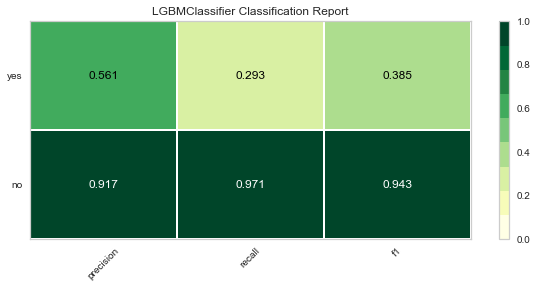

In [559]:
show_classification_rpt(LGBM)

In [560]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, LGBM_predict))

Confusion Matrix:
[[14226   420]
 [ 1293   537]]


### LGBM With Grid Search

In [561]:
lgbm_params = {
    'num_leaves': [31,35,41,45],
    'n_estimators': [50,75,100,150]
}

In [562]:
if grid_search_enable == True:
    lgbm_gs = GridSearchCV(LGBM, lgbm_params, cv=cv, n_jobs=number_of_jobs)
    lgbm_gs.fit(X_train_sm, y_train_sm)

In [563]:
if grid_search_enable == True:
    lgbm_best_estimator = lgbm_gs.best_params_['n_estimators']
    lgbm_best_num_leaves = lgbm_gs.best_params_['num_leaves']
    print(lgbm_gs.best_params_)

{'n_estimators': 50, 'num_leaves': 45}


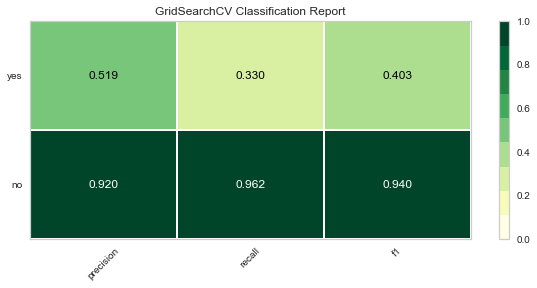

In [564]:
if grid_search_enable == True:
    show_classification_rpt(lgbm_gs)

### LGBM With Best Parameters

In [565]:
if grid_search_enable == True:
    LGBM_best = LGBMClassifier(n_jobs=number_of_jobs, num_leaves=lgbm_best_num_leaves, 
                               n_estimators=lgbm_best_estimator)
    LGBM_best.fit(X_train_sm, y_train_sm)

In [566]:
if grid_search_enable == True:
    LGBM_best_predict = LGBM_best.predict(X_test)
    LGBM_accuracy_score = accuracy_score(y_test,LGBM_best_predict)

In [567]:
if grid_search_enable == True:
    print("Accuracy with LGBM with Hyper Parameter Tuning", end=': ')
    print(LGBM_accuracy_score)

Accuracy with LGBM with Hyper Parameter Tuning: 0.8915999028890508


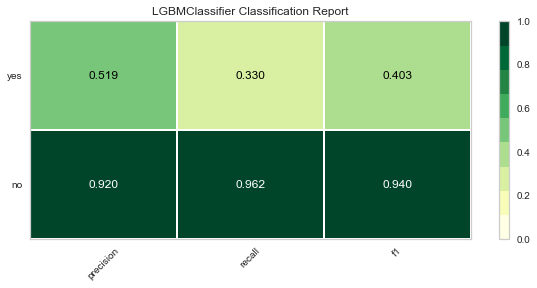

In [568]:
if grid_search_enable == True:
    show_classification_rpt(LGBM_best)

In [569]:
if grid_search_enable == True:
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, LGBM_best_predict))

Confusion Matrix:
[[14086   560]
 [ 1226   604]]


## XG Boost

In [570]:
from xgboost import XGBClassifier

In [ ]:
xgb_fit = XGBClassifier(max_depth=2, n_estimators=5000, random_state=rand_state, n_jobs=number_of_jobs)
xgb_fit.fit(X_train_sm, y_train_sm)

In [ ]:
print("Accuracy with XG Boost", end=': ')
xgb_predict = xgb_fit.predict(X_test)
xgb_accuracy = accuracy_score(y_test,xgb_predict)
print(xgb_accuracy)

In [ ]:
show_classification_rpt(xgb_fit)

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, xgb_predict))

### XG Boost with Grid Search

In [ ]:
xgb_params = {
    'max_depth': [2,3,4],
    'n_estimators': [300,500,700],
    'learning_rate': [0.05,0.075,0.1]
}

In [ ]:
xgb_gs = GridSearchCV(xgb_fit, xgb_params, cv=cv, n_jobs=number_of_jobs)

In [ ]:
if grid_search_enable == True:
    xgb_gs.fit(X_train_sm, y_train_sm)

In [ ]:
if grid_search_enable == True:
    print(xgb_gs.best_params_)

In [ ]:
if grid_search_enable == True:
    xgb_best_max_depth = xgb_gs.best_params_['max_depth']
    xgb_best_n_estimators = xgb_gs.best_params_['n_estimators']
    xgb_best_learning_rate = xgb_gs.best_params_['learning_rate']

### Re-running XG Boost with Best Parameters

In [ ]:
if grid_search_enable == True:
    xgb_best = XGBClassifier(max_depth=xgb_best_max_depth,
                             n_estimators=xgb_best_n_estimators, random_state=rand_state,
                             n_jobs=number_of_jobs, learning_rate = xgb_best_learning_rate)
    xgb_best.fit(X_train_sm, y_train_sm)
    xgb_best_predict = xgb_best.predict(X_test)

In [ ]:
if grid_search_enable == True:
    print("Accuracy with XG Boost after Hyper Parameter Tuning", end=': ')
    xgb_best_hyper_accuracy = accuracy_score(y_test, xgb_best_predict)
    print(xgb_best_hyper_accuracy)

In [ ]:
if grid_search_enable == True:
    show_classification_rpt(xgb_best)

In [ ]:
if grid_search_enable == True:
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, xgb_best_predict))

## Accuracy Summary With Boosting

In [ ]:
print("Accuracy with Logistic Regression", end=': ')
print(logit_accuracy)

print("Accuracy with Decision Tree", end=': ')
print(tree_accuracy)
print("Accuracy with Decision Tree after Hyper Parameter Tuning: ", end = ':')
print(dt_best_param_score)

print("Accuracy with Random Forest", end=': ')
print(rf_accuracy)
if grid_search_enable == True:
    print("Accuracy with Random Forest after Hyper Parameter Tuning", end=': ')
    print(rf_hyper_accuracy)

print("Accuracy with Ada Boost", end=': ')
print(ada_boost_accuracy)
if grid_search_enable == True:
    print("Accuracy with Ada Boost after Hyper Parameter Tuning", end=': ')
    print(ada_best_hyper_accuracy)

print("Accuracy with Gradient Boost", end=': ')
print(gbc_accuracy)
if grid_search_enable == True:
    print("Accuracy with Gradient Boost after Hyper Parameter Tuning", end=': ')
    print(gbc_best_hyper_accuracy)
    
print("Accuracy with LGBM", end=': ')
print(lgbm_accuracy)
if grid_search_enable == True:
    print("Accuracy with LGBM after Hyper Parameter Tuning", end=': ')
    print(LGBM_accuracy_score)
    
print("Accuracy with XG Boost", end=': ')
print(xgb_accuracy)
if grid_search_enable == True:
    print("Accuracy with XG Boost after Hyper Parameter Tuning", end=': ')
    print(xgb_best_hyper_accuracy)